In [30]:
import pandas as pd
import pybedtools

import numpy as np
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from ALLCools.plot.color import *

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.5
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

## SubType Bed

In [3]:
reptile_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/REPTILE/result/REPTILE_scores.subtype.h5ad'
)
enhancer_hits = pd.Series((reptile_adata.X > 0).sum(axis=1).A1, index=reptile_adata.obs_names)

sub_type_total_df = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/TotalDMR.nofilter.bed',
                                 header=None, sep='\t', index_col=3)
sub_type_total_df[1] -= 1

dmr_bed = pybedtools.BedTool.from_dataframe(sub_type_total_df)

sub_type_total_df = sub_type_total_df.loc[enhancer_hits[enhancer_hits > 0].index]
edmr_bed = pybedtools.BedTool.from_dataframe(sub_type_total_df)

In [4]:
sub_type_total_df[1].min()

734064

In [5]:
(sub_type_total_df[2] - sub_type_total_df[1]).describe()

count    1.612198e+06
mean     1.712693e+02
std      1.667462e+02
min      2.000000e+00
25%      5.700000e+01
50%      1.250000e+02
75%      2.290000e+02
max      3.463000e+03
dtype: float64

In [6]:
sub_type_total_df.shape

(1612198, 3)

## Fetal Brain Bed

In [8]:
fetal_dmr_bed = pybedtools.BedTool(
    '/home/hanliu/ref/inhouse/He_2020_Nature_Mouse_Tissue_Developmental/feDMR_brain.bed'
)

In [9]:
fetal_dmr_df = fetal_dmr_bed.to_dataframe()
(fetal_dmr_df['end'] - fetal_dmr_df['start']).describe()

count    213319.000000
mean        319.805470
std         237.459898
min           3.000000
25%         153.000000
50%         270.000000
75%         429.000000
max        5338.000000
dtype: float64

In [10]:
fetal_dmr_bed_slop = fetal_dmr_bed.slop(b=250, g='/home/hanliu/ref/mouse/genome/mm10.chrom.sizes')

## Fetal No Brain Bed

In [11]:
fetal_no_brain_dmr_bed = pybedtools.BedTool(
    '/home/hanliu/ref/inhouse/He_2020_Nature_Mouse_Tissue_Developmental/feDMR_no_brain.bed')

In [12]:
fetal_no_brain_dmr_df = fetal_no_brain_dmr_bed.to_dataframe()
(fetal_no_brain_dmr_df['end'] - fetal_no_brain_dmr_df['start']).describe()

count    254822.000000
mean        356.418210
std         266.195009
min           3.000000
25%         166.000000
50%         297.000000
75%         482.000000
max        5386.000000
dtype: float64

In [13]:
fetal_no_brain_dmr_slop = fetal_no_brain_dmr_bed.slop(b=250, g='/home/hanliu/ref/mouse/genome/mm10.chrom.sizes')

## Peaks Bed

In [14]:
peak_bed = pybedtools.BedTool(
    '/home/hanliu/project/mouse_rostral_brain/ATAC/peak/rs1atac.merged.reproduced.narrowPeak.bed'
)

In [15]:
peak_df = peak_bed.to_dataframe()
(peak_df['end'] - peak_df['start']).describe()

count    555903.000000
mean        712.649908
std         434.621446
min         200.000000
25%         398.000000
50%         591.000000
75%         895.000000
max        5753.000000
dtype: float64

In [16]:
peak_bed_slop = peak_bed.slop(b=250, g='/home/hanliu/ref/mouse/genome/mm10.chrom.sizes')

## Intersect

- DMR, eDMR, Peak
- eDMR, feDMR_brain, feDMR_no_brain

In [17]:
overlap_records = {}
overlap_records[('DMR', 'eDMR')] = dmr_bed.intersect(
    edmr_bed, wa=True, u=True).to_dataframe().shape[0]

overlap_records[('eDMR', 'peak')] = edmr_bed.intersect(
    peak_bed_slop, wa=True, u=True).to_dataframe().shape[0]

overlap_records[('peak', 'eDMR')] = peak_bed_slop.intersect(
    edmr_bed, wa=True, u=True).to_dataframe().shape[0]

overlap_records[('eDMR', 'feDMR_brain')] = edmr_bed.intersect(
    fetal_dmr_bed, wa=True, u=True).to_dataframe().shape[0]

overlap_records[('feDMR_brain', 'eDMR')] = fetal_dmr_bed.intersect(
    edmr_bed, wa=True, u=True).to_dataframe().shape[0]

overlap_records[('eDMR', 'feDMR_no_brain')] = edmr_bed.intersect(
    fetal_no_brain_dmr_bed, wa=True, u=True).to_dataframe().shape[0]

overlap_records[('feDMR_no_brain', 'eDMR')] = fetal_no_brain_dmr_bed.intersect(
    edmr_bed, wa=True, u=True).to_dataframe().shape[0]

overlap_records

{('DMR', 'eDMR'): 1612198,
 ('eDMR', 'peak'): 1170122,
 ('peak', 'eDMR'): 468922,
 ('eDMR', 'feDMR_brain'): 311313,
 ('feDMR_brain', 'eDMR'): 188697,
 ('eDMR', 'feDMR_no_brain'): 281682,
 ('feDMR_no_brain', 'eDMR'): 187411}

In [2]:
188697 / 213319, 187411 / 254822

(0.8845766199916557, 0.7354584768975991)

In [19]:
dmr_counts = {'DMR': dmr_bed.to_dataframe().shape[0],
              'eDMR': edmr_bed.to_dataframe().shape[0],
              'feDMR_brain': fetal_dmr_bed.to_dataframe().shape[0],
              'feDMR_no_brain': fetal_no_brain_dmr_bed.to_dataframe().shape[0],
              'peak': peak_bed.to_dataframe().shape[0]}

dmr_counts

{'DMR': 4722053,
 'eDMR': 1612198,
 'feDMR_brain': 213319,
 'feDMR_no_brain': 254822,
 'peak': 555903}

## Venn Plot

(<Figure size 360x72 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8c67162d68>)

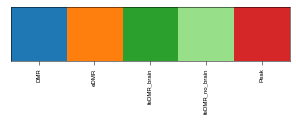

In [20]:
palette = {
    'DMR': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    'eDMR': (1.0, 0.4980392156862745, 0.054901960784313725),
    'feDMR_brain':
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    'feDMR_no_brain':
    (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    'Peak': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
}
palplot(palette)

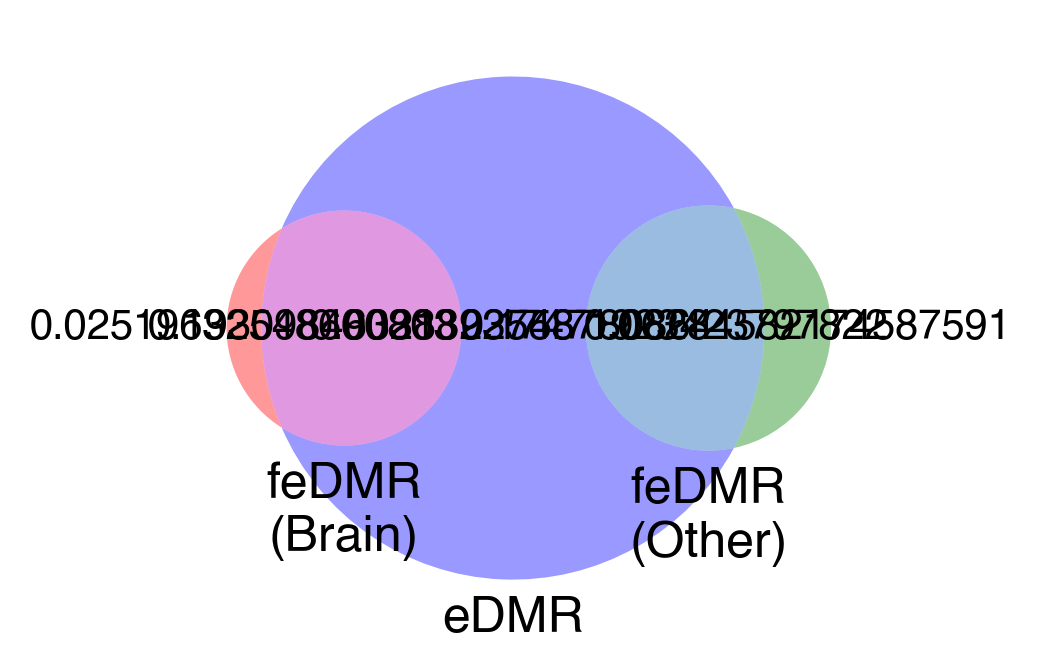

(0.02519632548600803,
 0.19309849038393548,
 0.6321822753780864,
 0.17471923423797822,
 0.06284582174587591)

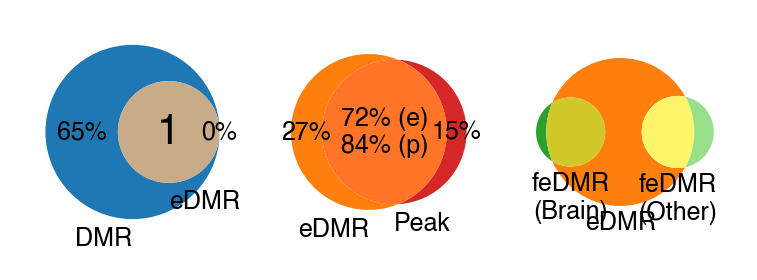

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(3, 1), dpi=300, ncols=3)

ax = ax1
a = overlap_records[('DMR', 'eDMR')] / dmr_counts['DMR']
b = overlap_records[('DMR', 'eDMR')] / dmr_counts['eDMR']
labels = ('DMR', 'eDMR')
v = venn2(subsets=((1 - a) / a, (1 - b) / b, 1),
          set_labels=labels,
          ax=ax,
          alpha=1,
          set_colors=[palette[c] for c in labels])
for label in v.set_labels:
    label.set(fontsize=labelsize)

numbers = [
    f'{int((1-a)*100)}%', f'{int((1-b)*100)}%'
]
for label, t in zip(v.subset_labels, numbers):
    label.set(text=t, fontsize=labelsize)

ax = ax2
a = overlap_records[('eDMR', 'peak')] / dmr_counts['eDMR']
b = overlap_records[('peak', 'eDMR')] / dmr_counts['peak']
labels = ('eDMR', 'Peak')
v = venn2(subsets=((1 - a) / a, (1 - b) / b, 1),
          set_labels=('eDMR', 'Peak'),
          ax=ax,
          alpha=1,
          set_colors=[palette[c] for c in labels])
for label in v.set_labels:
    label.set(fontsize=labelsize)
numbers = [
    f'{int((1-a)*100)}%', f'{int((1-b)*100)}%',
    f'{int(a*100)}% (e)\n{int(b*100)}% (p)', ''
]
for label, t in zip(v.subset_labels, numbers):
    label.set(text=t, fontsize=labelsize)

la = overlap_records[('feDMR_brain', 'eDMR')] / dmr_counts['feDMR_brain']
lb = overlap_records[('eDMR', 'feDMR_brain')] / dmr_counts['eDMR']
ra = overlap_records[('feDMR_no_brain', 'eDMR')] / dmr_counts['feDMR_no_brain']
rb = overlap_records[('eDMR', 'feDMR_no_brain')] / dmr_counts['eDMR']
center = 1 - lb - rb

# A corret portion ....
ax = ax3
v = venn3(subsets=((lb / la) - lb, (rb / ra) - rb, 0, center, lb, rb, 0),
      set_labels=('feDMR\n(Brain)', 'feDMR\n(Other)', 'eDMR'),
          ax=ax,
          alpha=1,
          set_colors=[palette[c] for c in ['feDMR_brain', 'feDMR_no_brain', 'eDMR']])
for label in v.set_labels:
    label.set(fontsize=labelsize)
numbers = [
    f'', f'', None,
    f'', f'', f'', None
]
for label, t in zip(v.subset_labels, numbers):
    if label is None:
        continue
    label.set(text=t, fontsize=labelsize)

fig.savefig('DMR_overlap_with_other.pdf')

## DMR corr 

In [67]:
corr_table = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/TotalGeneDMRCorrLoop.0.3.msg'
)
use_dmr = corr_table['DMR'].unique()
edmr_index = enhancer_hits[enhancer_hits > 0].index
corr_table = corr_table[corr_table['DMR'].isin(edmr_index)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [76]:
corr_table['DMR'].unique().size, edmr_index.size

(1017854, 1612198)

In [77]:
dmr_3 = corr_table[corr_table['Corr'] > 0.3]['DMR'].unique().size
dmr_5 = corr_table[corr_table['Corr'] > 0.5]['DMR'].unique().size

In [78]:
a = dmr_counts['eDMR']
b = dmr_3
c = dmr_5

a_only = a - b
b_only = 0
c_only = 0
a_b = b
a_c = 0
b_c = 0
a_b_c = c

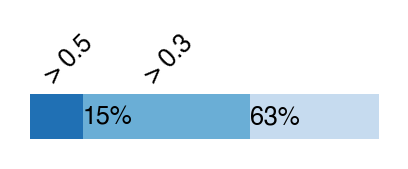

In [80]:
fig, ax = plt.subplots(figsize=(1.5, 0.4), dpi=300)

ax.axis('off')

from matplotlib.patches import Rectangle
ac, bc, cc = sns.color_palette("Blues", 3)
a_ = Rectangle((0, 0), a, 1, fc=ac)
b_ = Rectangle((0, 0), b, 1, fc=bc)
c_ = Rectangle((0, 0), c, 1, fc=cc)

ax.add_patch(a_)
ax.add_patch(b_)
ax.add_patch(c_)
ax.set_xlim(0, a)
ax.set_ylim(0, 2)
ax.text(c,
        0.5,
        f'{c / a * 100:.0f}%',
        ha='left',
        va='center',
        fontsize=labelsize)
ax.text(c / 5,
        1.8,
        f'> 0.5',
        rotation=45,
        ha='left',
        va='center',
        fontsize=labelsize)

ax.text(b,
        0.5,
        f'{b / a * 100:.0f}%',
        ha='left',
        va='center',
        fontsize=labelsize)
ax.text(b / 2,
        1.8,
        f'> 0.3',
        rotation=45,
        ha='left',
        va='center',
        fontsize=labelsize)

fig.savefig('DMR_corr_portion.pdf')